In [7]:
# Imports
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from collections import deque
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
import os

In [8]:
# Tic-Tac-Toe Environment Setup
class TicTacToeEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros(9, dtype=int)
        self.done = False
        self.winner = None
        self.current_player = 1  # 1 for 'X' (AI), -1 for 'O' (Opponent)
        return self.get_state()

    def get_valid_actions(self):
        return np.where(self.board == 0)[0]

    def step(self, action):
        if self.board[action] != 0 or self.done:
            # Invalid move
            return self.get_state(), -10, True, {}

        self.board[action] = self.current_player
        reward = self.check_winner()
        done = self.done
        winner = self.winner
        self.current_player *= -1  # Switch player
        return self.get_state(), reward, done, {}

    def check_winner(self):
        win_states = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6]              # Diagonals
        ]
        for state in win_states:
            line = self.board[state]
            if np.all(line == self.current_player):
                self.done = True
                self.winner = self.current_player
                return 1  # Reward for winning
        if np.all(self.board != 0):
            self.done = True
            self.winner = 0  # Draw
            return 0.5  # Reward for draw
        return 0  # No result yet

    def get_state(self):
        return self.board.copy()

    def render(self):
        symbols = {1: 'X', -1: 'O', 0: ' '}
        print("\nCurrent Board:")
        for i in range(9):
            print(f" {symbols[self.board[i]]} ", end='')
            if (i + 1) % 3 == 0:
                if i != 8:
                    print("\n---+---+---")
                else:
                    print("\n")
            else:
                print("|", end='')

In [9]:
# Lorenz Attractor for Noise Generation
class LorenzAttractor:
    def __init__(self, sigma=10.0, rho=28.0, beta=8.0/3.0):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.state = np.array([1.0, 1.0, 1.0])  # Initial condition
        self.t = 0.0

    def lorenz(self, t, state):
        x, y, z = state
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z
        return [dxdt, dydt, dzdt]

    def step(self, dt=0.01):
        sol = solve_ivp(self.lorenz, [self.t, self.t + dt], self.state, method='RK45')
        self.state = sol.y[:, -1]
        self.t += dt
        return self.state[0]  # Returning only x as noise value

In [10]:
# DQN Agent Implementation
class DQNAgent:
    def __init__(self, state_size=9, action_size=9):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 32
        self.train_start = 500
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.lorenz_attractor = LorenzAttractor()

    def _build_model(self):
        model = models.Sequential()
        model.add(layers.Input(shape=(self.state_size,)))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(self.action_size, activation='linear'))

        model.compile(loss='huber', optimizer=optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(valid_actions)
        state_input = np.reshape(state, [1, self.state_size])  # Reshape here
        act_values = self.model.predict(state_input, verbose=0)[0]

        # Adding Lorenz Attractor noise
        noise = self.lorenz_attractor.step()
        act_values = act_values + noise

        # Mask invalid actions by setting their Q-values to -infinity
        masked_act_values = np.array([act_values[i] if i in valid_actions else -np.inf for i in range(self.action_size)])

        # Choose the action with the highest Q-value among valid actions
        return np.argmax(masked_act_values)

    def replay(self):
        if len(self.memory) < self.train_start:
            return None  # Not enough memories to train

        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        states = np.array([m[0] for m in minibatch])
        actions = [m[1] for m in minibatch]
        rewards = [m[2] for m in minibatch]
        next_states = np.array([m[3] for m in minibatch])
        dones = [m[4] for m in minibatch]

        # Predict Q-values for current states and next states
        target = self.model.predict(states, verbose=0)
        target_next = self.target_model.predict(next_states, verbose=0)

        for i in range(len(minibatch)):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.gamma * np.amax(target_next[i])

        # Train the model
        history = self.model.fit(states, target, epochs=1, verbose=0)
        loss = history.history['loss'][0]

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

    def train_self_play(self, episodes=500):
        env = TicTacToeEnv()
        for e in range(episodes):
            state = env.reset()
            total_reward = 0

            while not env.done:
                # AI's turn
                valid_actions = env.get_valid_actions()
                action = self.act(state, valid_actions)
                next_state, reward, done, _ = env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                if done:
                    break

                # Opponent's turn (another AI)
                opponent_valid_actions = env.get_valid_actions()
                opponent_action = self.act(state, opponent_valid_actions)
                next_state, reward, done, _ = env.step(opponent_action)
                self.remember(state, opponent_action, reward, next_state, done)
                state = next_state
                total_reward += reward

            self.update_target_model()
            loss = self.replay()

            if (e + 1) % 50 == 0:
                print(f"Self-Play Episode {e + 1}/{episodes} - Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

    def load(self, name):
        if os.path.exists(name):
            self.model = models.load_model(name)
            self.target_model = models.load_model(name)
            print(f"Model loaded from {name}")
        else:
            print(f"No model found at {name}, starting fresh.")

    def save(self, name):
        self.model.save(name)
        print(f"Model saved to {name}")

    def train_after_game(self):
        if len(self.memory) >= self.train_start:
            self.replay()
            self.update_target_model()

In [11]:
# Training Loop
def train_agent(agent, env, episodes=1000):
    losses = []
    rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0

        while not env.done:
            # AI's turn
            valid_actions = env.get_valid_actions()
            action = agent.act(state, valid_actions)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # Opponent's turn (random)
            opponent_valid_actions = env.get_valid_actions()
            if len(opponent_valid_actions) == 0:
                break  # No moves left
            opponent_action = np.random.choice(opponent_valid_actions)
            next_state, reward, done, _ = env.step(opponent_action)
            if done and env.winner == -1:
                agent.remember(state, opponent_action, -1, next_state, done)
                total_reward += -1
            else:
                agent.remember(state, opponent_action, reward, next_state, done)
                total_reward += reward
            state = next_state

        loss = agent.replay()
        if loss is not None:
            losses.append(loss)
        rewards.append(total_reward)

        if (e + 1) % 50 == 0:
            agent.update_target_model()

        if (e + 1) % 200 == 0:
            avg_reward = np.mean(rewards[-200:])
            avg_loss = np.mean(losses[-200:]) if losses else 0
            print(f"Episode {e + 1}/{episodes} - Avg Reward: {avg_reward:.2f}, Avg Loss: {avg_loss:.4f}, Epsilon: {agent.epsilon:.4f}")

        if (e + 1) % 200 == 0:
            plot_training_progress(rewards, losses)

    return rewards, losses

In [12]:
# Function to Dynamically Plot Training Progress
def plot_training_progress(rewards, losses):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(rewards, label='Total Reward per Episode', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards over Episodes')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(losses, label='Loss per Episode', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Loss over Episodes')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
def user_vs_ai(model, agent):
    env = TicTacToeEnv()
    user_turn = True

    while True:
        choice = input("Do you want to go first? (y/n): ").strip().lower()
        if choice in ['y', 'yes']:
            user_turn = True
            break
        elif choice in ['n', 'no']:
            user_turn = False
            break
        else:
            print("Invalid input. Please enter 'y' or 'n'.")

    env.reset()
    env.render()

    while not env.done:
        if user_turn:
            while True:
                try:
                    move = input("Enter your move (0-8): ").strip()
                    move = int(move)
                    if move not in env.get_valid_actions():
                        print(f"Invalid move. Position {move} is either occupied or out of range. Try again.")
                        continue
                    env.step(move)
                    break
                except ValueError:
                    print("Invalid input. Please enter a number between 0 and 8.")

            env.render()

            if env.done:
                if env.winner == 1:
                    print("Congratulations! You win!")
                elif env.winner == -1:
                    print("AI wins! Better luck next time.")
                else:
                    print("It's a draw!")
                break

            user_turn = False

        else:
            valid_actions = env.get_valid_actions()
            state = env.get_state()
            action = agent.act(state, valid_actions)
            env.step(action)
            print(f"Agent moves to position {action}")
            env.render()

            if env.done:
                if env.winner == -1:
                    print("A wins!")
                elif env.winner == 1:
                    print("You win!")
                else:
                    print("It's a draw!")
                break

            user_turn = True

        agent.train_after_game()

    while True:
        replay = input("Do you want to play again? (y/n): ").strip().lower()
        if replay in ['y', 'yes']:
            user_vs_ai(model, agent)
            break
        elif replay in ['n', 'no']:
            break
        else:
            print("Invalid input. Please enter 'y' or 'n'.")

No model found at tictactoe_dqn.model.keras, starting fresh.
Do you want to train the AI? (y/n): y
Enter the number of training episodes (e.g., 1000): 500
Starting training...
Episode 200/500 - Avg Reward: 0.44, Avg Loss: 0.3052, Epsilon: 0.5083


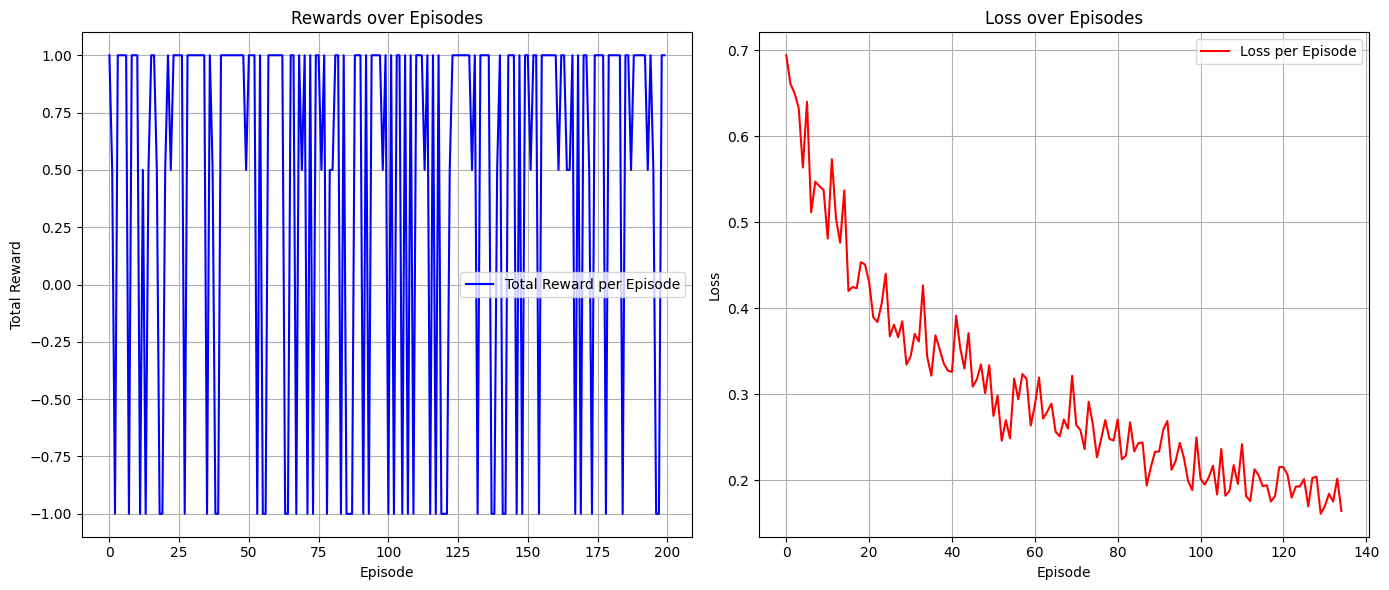

Episode 400/500 - Avg Reward: 0.32, Avg Loss: 0.1242, Epsilon: 0.1865


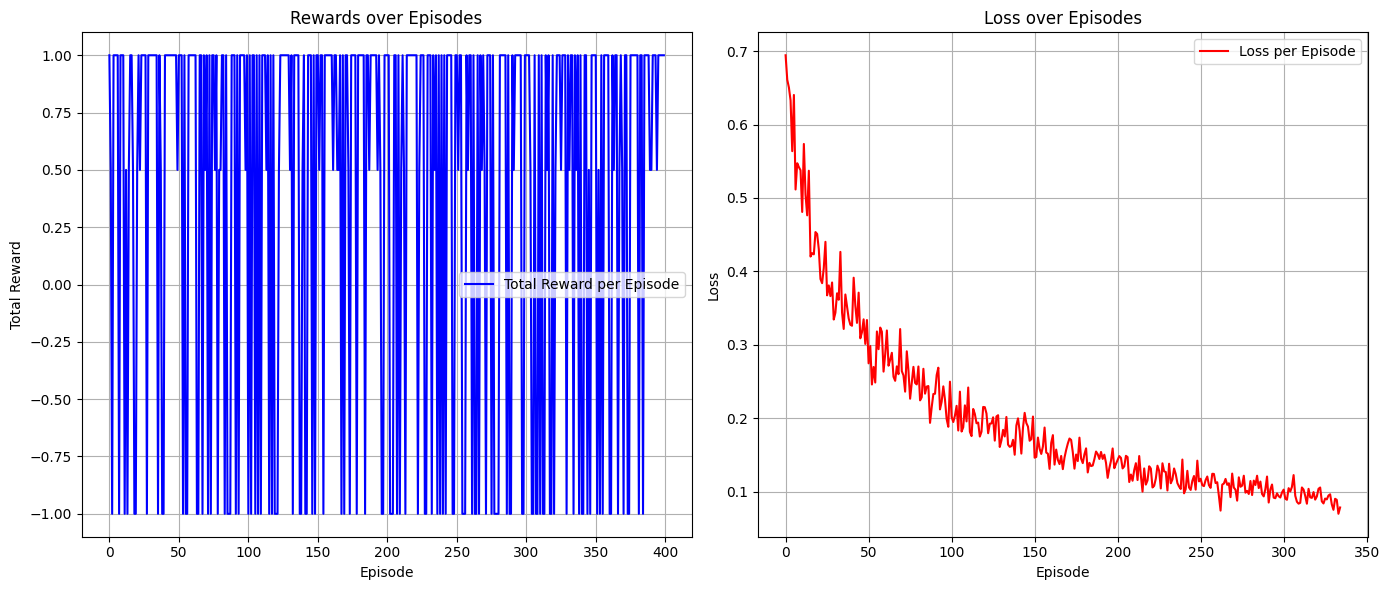

Model saved to tictactoe_dqn.model.keras
Training completed and model saved.
Do you want to play against the AI? (y/n): y
Do you want to go first? (y/n): y

Current Board:
   |   |   
---+---+---
   |   |   
---+---+---
   |   |   

Enter your move (0-8): 1

Current Board:
   | X |   
---+---+---
   |   |   
---+---+---
   |   |   

Agent moves to position 5

Current Board:
   | X |   
---+---+---
   |   | O 
---+---+---
   |   |   

Enter your move (0-8): 4

Current Board:
   | X |   
---+---+---
   | X | O 
---+---+---
   |   |   

Agent moves to position 7

Current Board:
   | X |   
---+---+---
   | X | O 
---+---+---
   | O |   

Enter your move (0-8): 2

Current Board:
   | X | X 
---+---+---
   | X | O 
---+---+---
   | O |   

Agent moves to position 6

Current Board:
   | X | X 
---+---+---
   | X | O 
---+---+---
 O | O |   

Enter your move (0-8): 8

Current Board:
   | X | X 
---+---+---
   | X | O 
---+---+---
 O | O | X 

Agent moves to position 3

Current Board:
   | X |

In [15]:
# Main Execution Block
if __name__ == "__main__":
    env = TicTacToeEnv()
    agent = DQNAgent()

    model_path = 'tictactoe_dqn.model.keras'
    agent.load(model_path)

    train_choice = input("Do you want to train the AI? (y/n): ").strip().lower()
    if train_choice in ['y', 'yes']:
        training_episodes = int(input("Enter the number of training episodes (e.g., 1000): ").strip())
        print("Starting training...")
        rewards, losses = train_agent(agent, env, episodes=training_episodes)
        agent.save(model_path)
        print("Training completed and model saved.")
    else:
        print("Skipping training phase.")

    play_choice = input("Do you want to play against the AI? (y/n): ").strip().lower()
    if play_choice in ['y', 'yes']:
        user_vs_ai(agent.model, agent)
    else:
        print("Exiting the program.")